Notebook for static HTML NetworkX plotting of feature maps

In [1]:
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import webbrowser
import os
import pandas as pd
import random
import string
import statistics
from src import create_fake_patients, whole_model_demographics_gradcam, graph_plot, plot_feature_value
from tensorflow import keras
import tensorflow as tf
from csv import writer
import seaborn as sns
import matplotlib.pyplot as plt
print("tensorflow version:", tf. __version__)
tf.config.list_physical_devices()

second_TGCNN_layer = True
demo = True

include_drugs = False
max_timesteps=100

run_name='hip_1999_to_one_year_advance_model'
years_in_advance = "5"

if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512
hip_or_knee = 'hip'



model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=16, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=4, variable_gamma=True, 
                            exponential_scaling=True, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=False, stride=1, activation_type='LeakyReLU', 
                            no_timestamp=False, second_TGCNN_layer=second_TGCNN_layer, num_labels=1)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')

# Generate individual data for the model

input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0)

logits = model(input_4d, demo_tensor, training=False)

grads = model.dy_du_branch1
print(grads.shape)

tensorflow version: 2.10.1
tensorflow version: 2.10.1
normalised gamma [[-0.01253964]]
normalised gamma [[0.03606927]]
(1, 16, 97)


# Branch 1

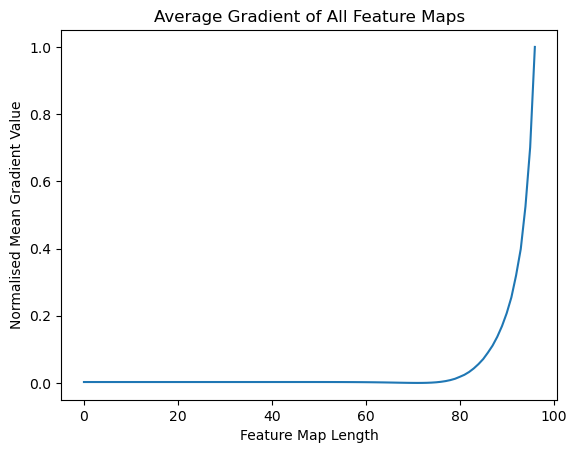

In [2]:
norm_features = plot_feature_value.plot_ave_grad_all_f_maps(grads)

## Subgraph plot of timestep with highest feature values - Branch 1

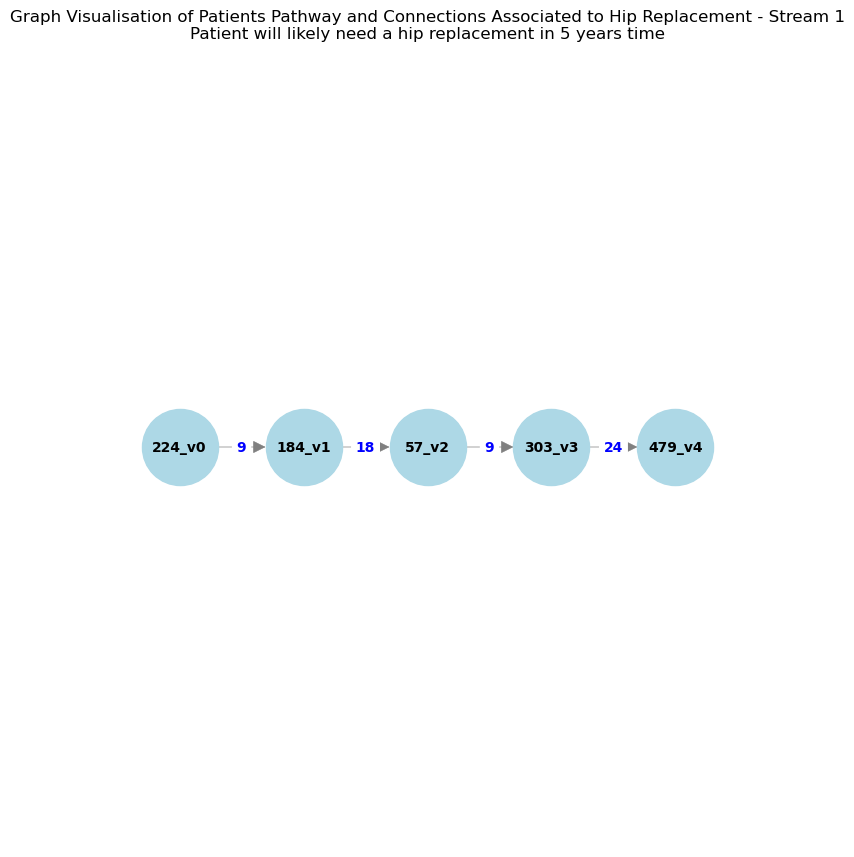

Graph image saved as documentation/pat_graph.png
HTML file saved as index.html


True

In [3]:
# Get the index of the with the largest number
max_val_idx = np.argmax(norm_features)
#print(max_val_idx)

# Get the indexes for the respective filter in terms of the timesteps i.e. index + filter size -1 
filter_size = 4
timestep_max_idx = max_val_idx + filter_size
#print(timestep_max_idx)


# Turn the sparse input graph into a dense graph
dense_tensor = tf.sparse.to_dense(input_3d) # input_3d is before the extra dimension is added for batching
dense_tensor

# Reshape to match graph visualisation code (and how I picture it in my noggin)
dense_tensor = tf.transpose(dense_tensor, perm=[2, 1, 0])
#print(dense_tensor.shape)

# Flip the graph so the most recent timesteps are at the front rather than the back
dense_tensor = np.flip(dense_tensor, axis=0)

#print(dense_tensor.shape)

# Get the chunk of the input graph that corresponds to these timesteps
max_visits = 100
pat_subgraph = dense_tensor[max_visits-timestep_max_idx:max_visits-max_val_idx, :, :] # this need to be 100 minus these values as the tensor has been flipped


## Turn these input tensors into a NetworkX graph

# Get the edges for the graph
edges_df = graph_plot.create_edges_df_gc(pat_subgraph)
#print(edges_df)

# Get the node positions for the graph
pos_df = graph_plot.create_position_df_gc(edges_df)
pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)
pos_dict = graph_plot.create_pos_dict(pos_df)
# Draw the graph and display on HTML
graph_name = 'pat_graph'
image_path = 'documentation/'+graph_name+'.png'
html_path = 'index.html'
graph_plot.draw_gc_pat_graph(edges_df, pos_dict, graph_name=graph_name, pat_outcome=outcome)
graph_plot.create_scrollable_html(image_path, html_path)
print(f"Graph image saved as {image_path}")
print(f"HTML file saved as {html_path}")

# Open the HTML file
file_url = 'file://' + os.path.realpath(html_path)
webbrowser.open(file_url)

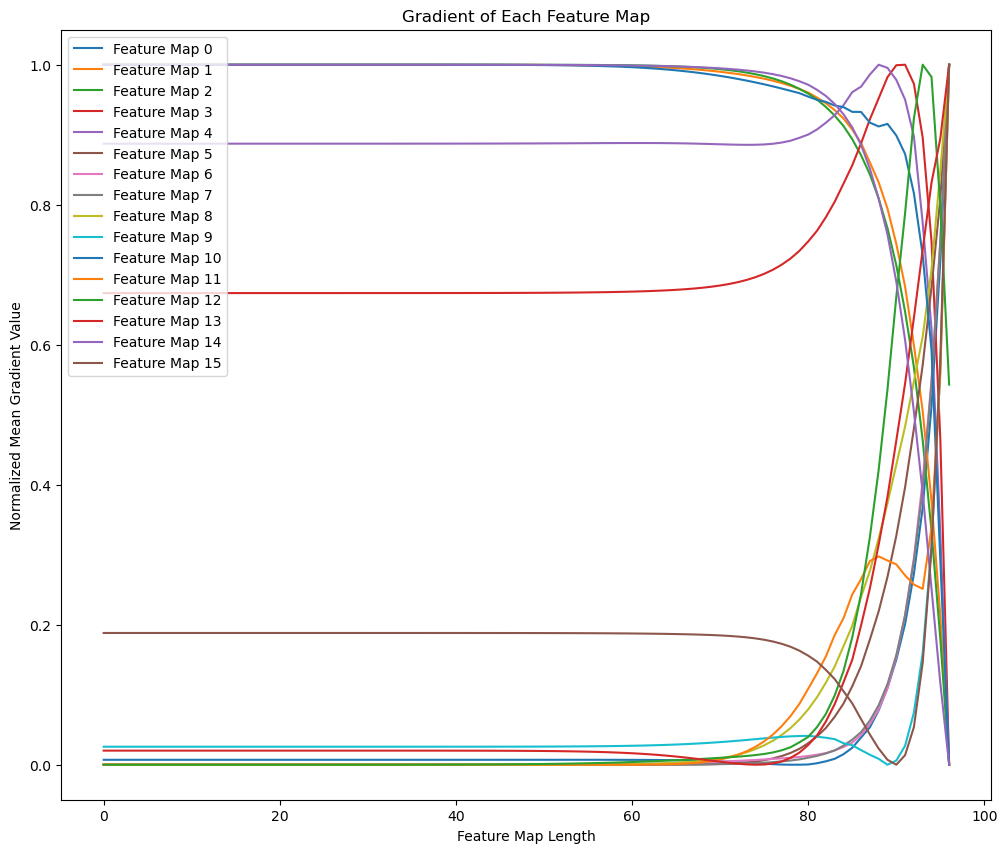

In [4]:
plot_feature_value.plot_indv_grad_f_maps(grads)

# Branch 2

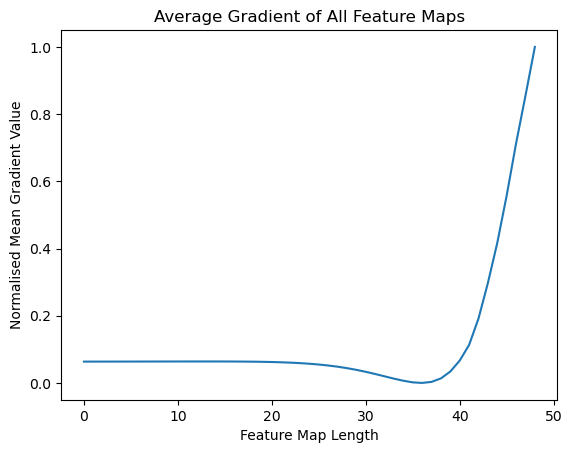

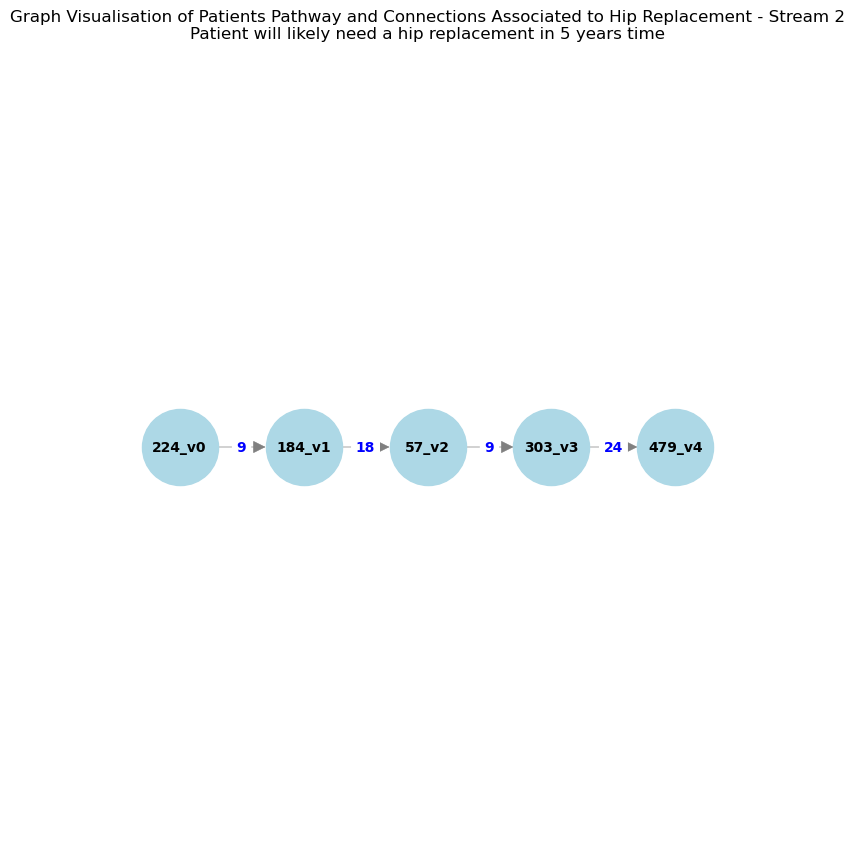

Graph image saved as documentation/pat_graph_stream2.png
HTML file saved as index_stream2.html


In [5]:
if second_TGCNN_layer:
    grads2 = model.dy_du_branch2

    norm_features2 = plot_feature_value.plot_ave_grad_all_f_maps(grads2)

    # Get the index of the with the largest number
    max_val_idx = np.argmax(norm_features2)
    # print(max_val_idx)

    # Get the indexes for the respective filter in terms of the timesteps i.e. (index*stride) + filter size -1 
    # As the stride size in branch 2 is different I need to map the feature index back to the input graph differently
    # ((timesteps - filter_size)/stride)+1 = ((200 - 6)/2)+1 =  final feature map size
    stream_2_stride = 2
    timestep_max_idx = (max_val_idx*stream_2_stride) + filter_size
    # print(timestep_max_idx)


    # Turn the sparse input graph into a dense graph
    dense_tensor = tf.sparse.to_dense(input_3d) # input_3d is before the extra dimension is added for batching

    # Reshape to match graph visualisation code (and how I picture it in my noggin)
    dense_tensor = tf.transpose(dense_tensor, perm=[2, 1, 0])
    #print(dense_tensor.shape)

    # Flip the graph so the most recent timesteps are at the front rather than the back
    dense_tensor = np.flip(dense_tensor, axis=0)

    # print(dense_tensor.shape)

    # Get the chunk of the input graph that corresponds to these timesteps
    max_visits = 100

    # print(max_visits-timestep_max_idx, max_visits-max_val_idx)
    pat_subgraph = dense_tensor[max_visits-timestep_max_idx:max_visits-timestep_max_idx+filter_size, :, :]
    #print(pat_subgraph)


    ## Turn these input tensors into a NetworkX graph

    # Get the edges for the graph
    edges_df = graph_plot.create_edges_df_gc(pat_subgraph)
    # print(edges_df)

    # Get the node positions for the graph
    pos_df = graph_plot.create_position_df_gc(edges_df)
    pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
    pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)
    pos_dict = graph_plot.create_pos_dict(pos_df)


    # Draw the graph and display on HTML
    graph_name = 'pat_graph_stream2'
    image_path = 'documentation/'+graph_name+'.png'
    html_path = 'index_stream2.html'
    graph_plot.draw_gc_pat_graph(edges_df, pos_dict, graph_name=graph_name, pat_outcome= outcome, stream_num=2)
    graph_plot.create_scrollable_html(image_path, html_path)
    print(f"Graph image saved as {image_path}")
    print(f"HTML file saved as {html_path}")
    
    # Open the HTML file
    file_url = 'file://' + os.path.realpath(html_path)
    webbrowser.open(file_url)

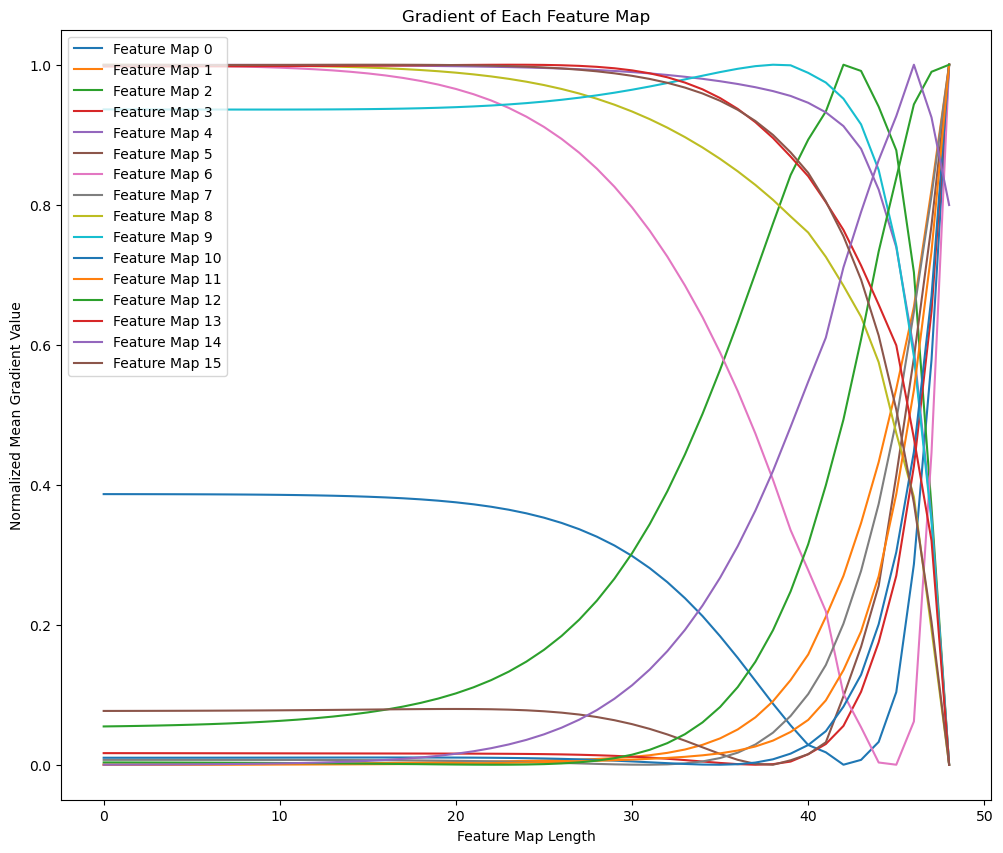

In [6]:
plot_feature_value.plot_indv_grad_f_maps(grads2)